# Figure X.x - Supervised model performance

Goals : 

- Show that 3D models outperform usual 2D models

In [1]:
import numpy as np
from tifffile import imread
import sys
import numpy as np

import pyclesperanto_prototype as cle
from stardist.matching import matching_dataset
sys.path.append("../..")

from utils import *
from plots import *
print("Used GPU: ", cle.get_device())
show_params()
#################
SAVE_PLOTS_AS_PNG = False
SAVE_PLOTS_AS_SVG = False

Used GPU:  <Intel(R) UHD Graphics 620 on Platform: Intel(R) OpenCL (1 refs)>
Plot parameters (set in plots.py) : 
- COLORMAP : ██████████
- DPI : 200
- Data path : C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK
- Font size : 15
- Title font size : 26
- Label font size : 18


In [2]:
%load_ext autoreload
%autoreload 2

## Data

In [3]:
data_path = DATA_PATH / "RESULTS/SUPERVISED_PERF_FIG/INFERENCE"
fold1_path = data_path / "fold1"
fold2_path = data_path / "fold2"
fold3_path = data_path / "fold3"

def get_fold_data(fold_path):
    return [imread(f) for f in fold_path.glob("*.tif") if "label" not in f.name], [imread(f) for f in fold_path.glob("*.tif") if "label" in f.name]

images = []
GT_labels = []
for fold in [fold1_path, fold2_path, fold3_path]:
    im, GT_lab = get_fold_data(fold)
    images.append(im[0])
    GT_labels.append(GT_lab[0])

In [4]:
fold_paths = [fold1_path, fold2_path, fold3_path]

def get_predictions(path):
    return [imread(f) for f in path.glob("*.tif")]
#################
swin_paths = [f / "Swin" for f in fold_paths]
segresnet_paths = [f / "SegResNet" for f in fold_paths]
#################
cellpose_paths = [f / "Cellpose" for f in fold_paths]
stardist_paths = [f / "stardist" for f in fold_paths]

swin_predictions = [get_predictions(p)[0] for p in swin_paths]
segresnet_predictions = [get_predictions(p)[0] for p in segresnet_paths]
# cellpose_predictions = [get_predictions(p)[0] for p in cellpose_paths]
stardist_predictions = [get_predictions(p)[0] for p in stardist_paths]

## Computations

In [5]:
swin_thresholded = [np.where(swin > 0.5, swin, 0) for swin in swin_predictions]
segresnet_thresholded = [np.where(segresnet > 0.45, segresnet, 0) for segresnet in segresnet_predictions]

In [6]:
swin_instance = []
segresnet_instance = []

for i in range(len(fold_paths)):
    swin_instance.append(np.array(
        cle.voronoi_otsu_labeling(swin_thresholded[i], spot_sigma=0.65, outline_sigma=0.65))
                         )
    segresnet_instance.append(np.array(
        cle.voronoi_otsu_labeling(segresnet_thresholded[i], spot_sigma=0.65, outline_sigma=0.65))
                              )

In [79]:
# from tifffile import imwrite
# for i in range(len(fold_paths)):
#     save_folder = data_path / "processed" / f"fold{i+1}"
#     save_folder.mkdir(exist_ok=True, parents=False)
#     imwrite(save_folder / "swin_instance.tif", swin_instance[i])
#     imwrite(save_folder / "segresnet_instance.tif", segresnet_instance[i])

## Plots

In [17]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predictions = [
   swin_instance,
   segresnet_instance,
   stardist_predictions,
   ]
names = ["Swin",
         "SegResNet",
         # "Cellpose",
         "Stardist"
         ]

model_stats = []
model_ref_name = []
fold_ref = []

for j, fold in enumerate(fold_paths):
    print("Fold ", j+1)
    for i, p in enumerate(predictions):
        print(f"Validating on {names[i]}")
        stats = [matching_dataset(
            GT_labels[j], p[j], thresh=t, show_progress=False
            ) for t in taus]
        model_stats.append(stats)
        for t in taus:
            model_ref_name.append(names[i])
            fold_ref.append(j+1)
        # uncomment for ALL plots : 
        # plot_performance(taus, stats, name=names[i])
        print("*"*20)

Fold  1
Validating on Swin
********************
Validating on SegResNet
********************
Validating on Stardist
********************
Fold  2
Validating on Swin
********************
Validating on SegResNet
********************
Validating on Stardist
********************
Fold  3
Validating on Swin
********************
Validating on SegResNet
********************
Validating on Stardist
********************


In [30]:
dfs = [dataset_matching_stats_to_df(s) for s in model_stats]
df = pd.concat(dfs)
df["Model"] = model_ref_name
df["Fold"] = fold_ref
df["thresh"] = df.index
df.set_index(["Model", "Fold", "thresh"], inplace=True)
df

criterion    fp    tp    fn  precision    recall  \
Model    Fold thresh                                                    
Swin     1    0.1          iou   221  2793   592   0.926676  0.825111   
              0.2          iou   248  2766   619   0.917717  0.817134   
              0.3          iou   312  2702   683   0.896483  0.798227   
              0.4          iou   379  2635   750   0.874253  0.778434   
              0.5          iou   479  2535   850   0.841075  0.748892   
...                        ...   ...   ...   ...        ...       ...   
Stardist 3    0.5          iou  6486  1147  5762   0.150269  0.166015   
              0.6          iou  7179   454  6455   0.059479  0.065711   
              0.7          iou  7415   218  6691   0.028560  0.031553   
              0.8          iou  7500   133  6776   0.017424  0.019250   
              0.9          iou  7576    57  6852   0.007468  0.008250   

                      accuracy        f1  n_true  n_pred  mean_true_score  \
Model    Fold thresh                                                        
Swin     1    0.1     0.774542  0.872949    3385    3014         0.614096   
              0.2     0.761354  0.864510    3385    3014         0.613144   
              0.3     0.730863  0.844507    3385    3014         0.608406   
              0.4     0.700053  0.823566    3385    3014         0.601647   
              0.5     0.656056  0.792311    3385    3014         0.588905   
...                        ...       ...     ...     ...              ...   
Stardist 3    0.5     0.085629  0.157750    6909    7633         0.101371   
              0.6     0.032226  0.062440    6909    7633         0.048145   
              0.7     0.015219  0.029982    6909    7633         0.026352   
              0.8     0.009230  0.018292    6909    7633         0.017269   
              0.9     0.003935  0.007839    6909    7633         0.008236   

                      mean_matched_score  panoptic_quality  by_image  
Model    Fold thresh                                                  
Swin     1    0.1               0.744259          0.649700     False  
              0.2               0.750359          0.648693     False  
              0.3               0.762196          0.643680     False  
              0.4               0.772894          0.636529     False  
              0.5               0.786368          0.623048     False  
...                                  ...               ...       ...  
Stardist 3    0.5               0.610610          0.096324     False  
              0.6               0.732678          0.045748     False  
              0.7               0.835162          0.025040     False  
              0.8               0.897081          0.016409     False  
              0.9               0.998246          0.007826     False  

[81 rows x 14 columns]

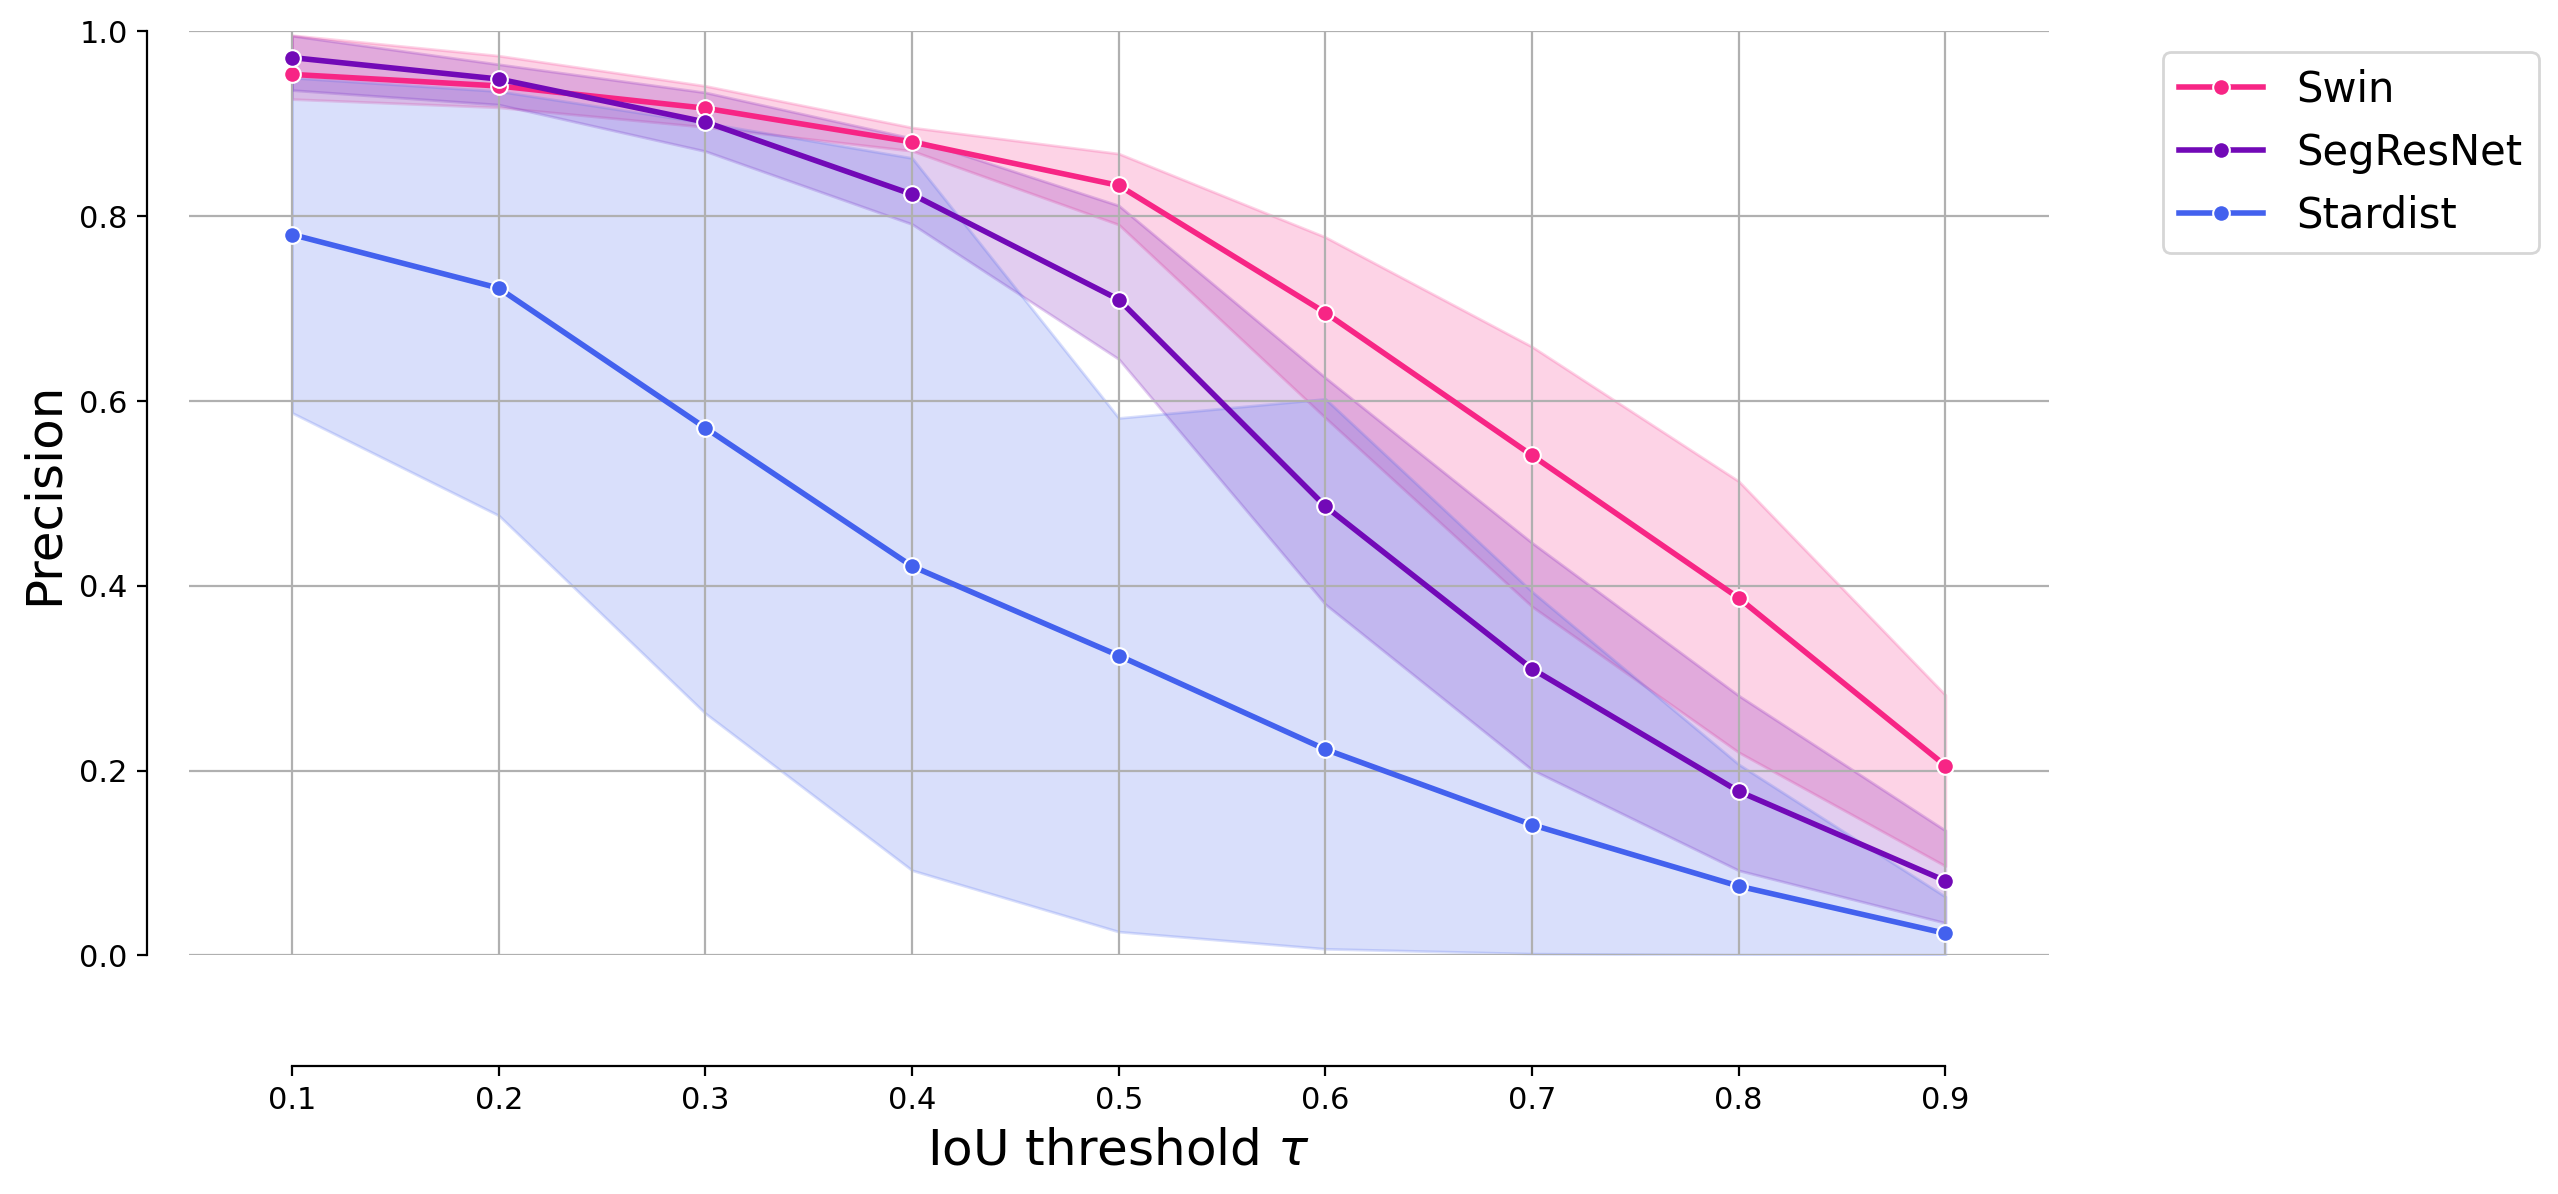

In [37]:
plot_stat_comparison_fold(df, stat="precision")

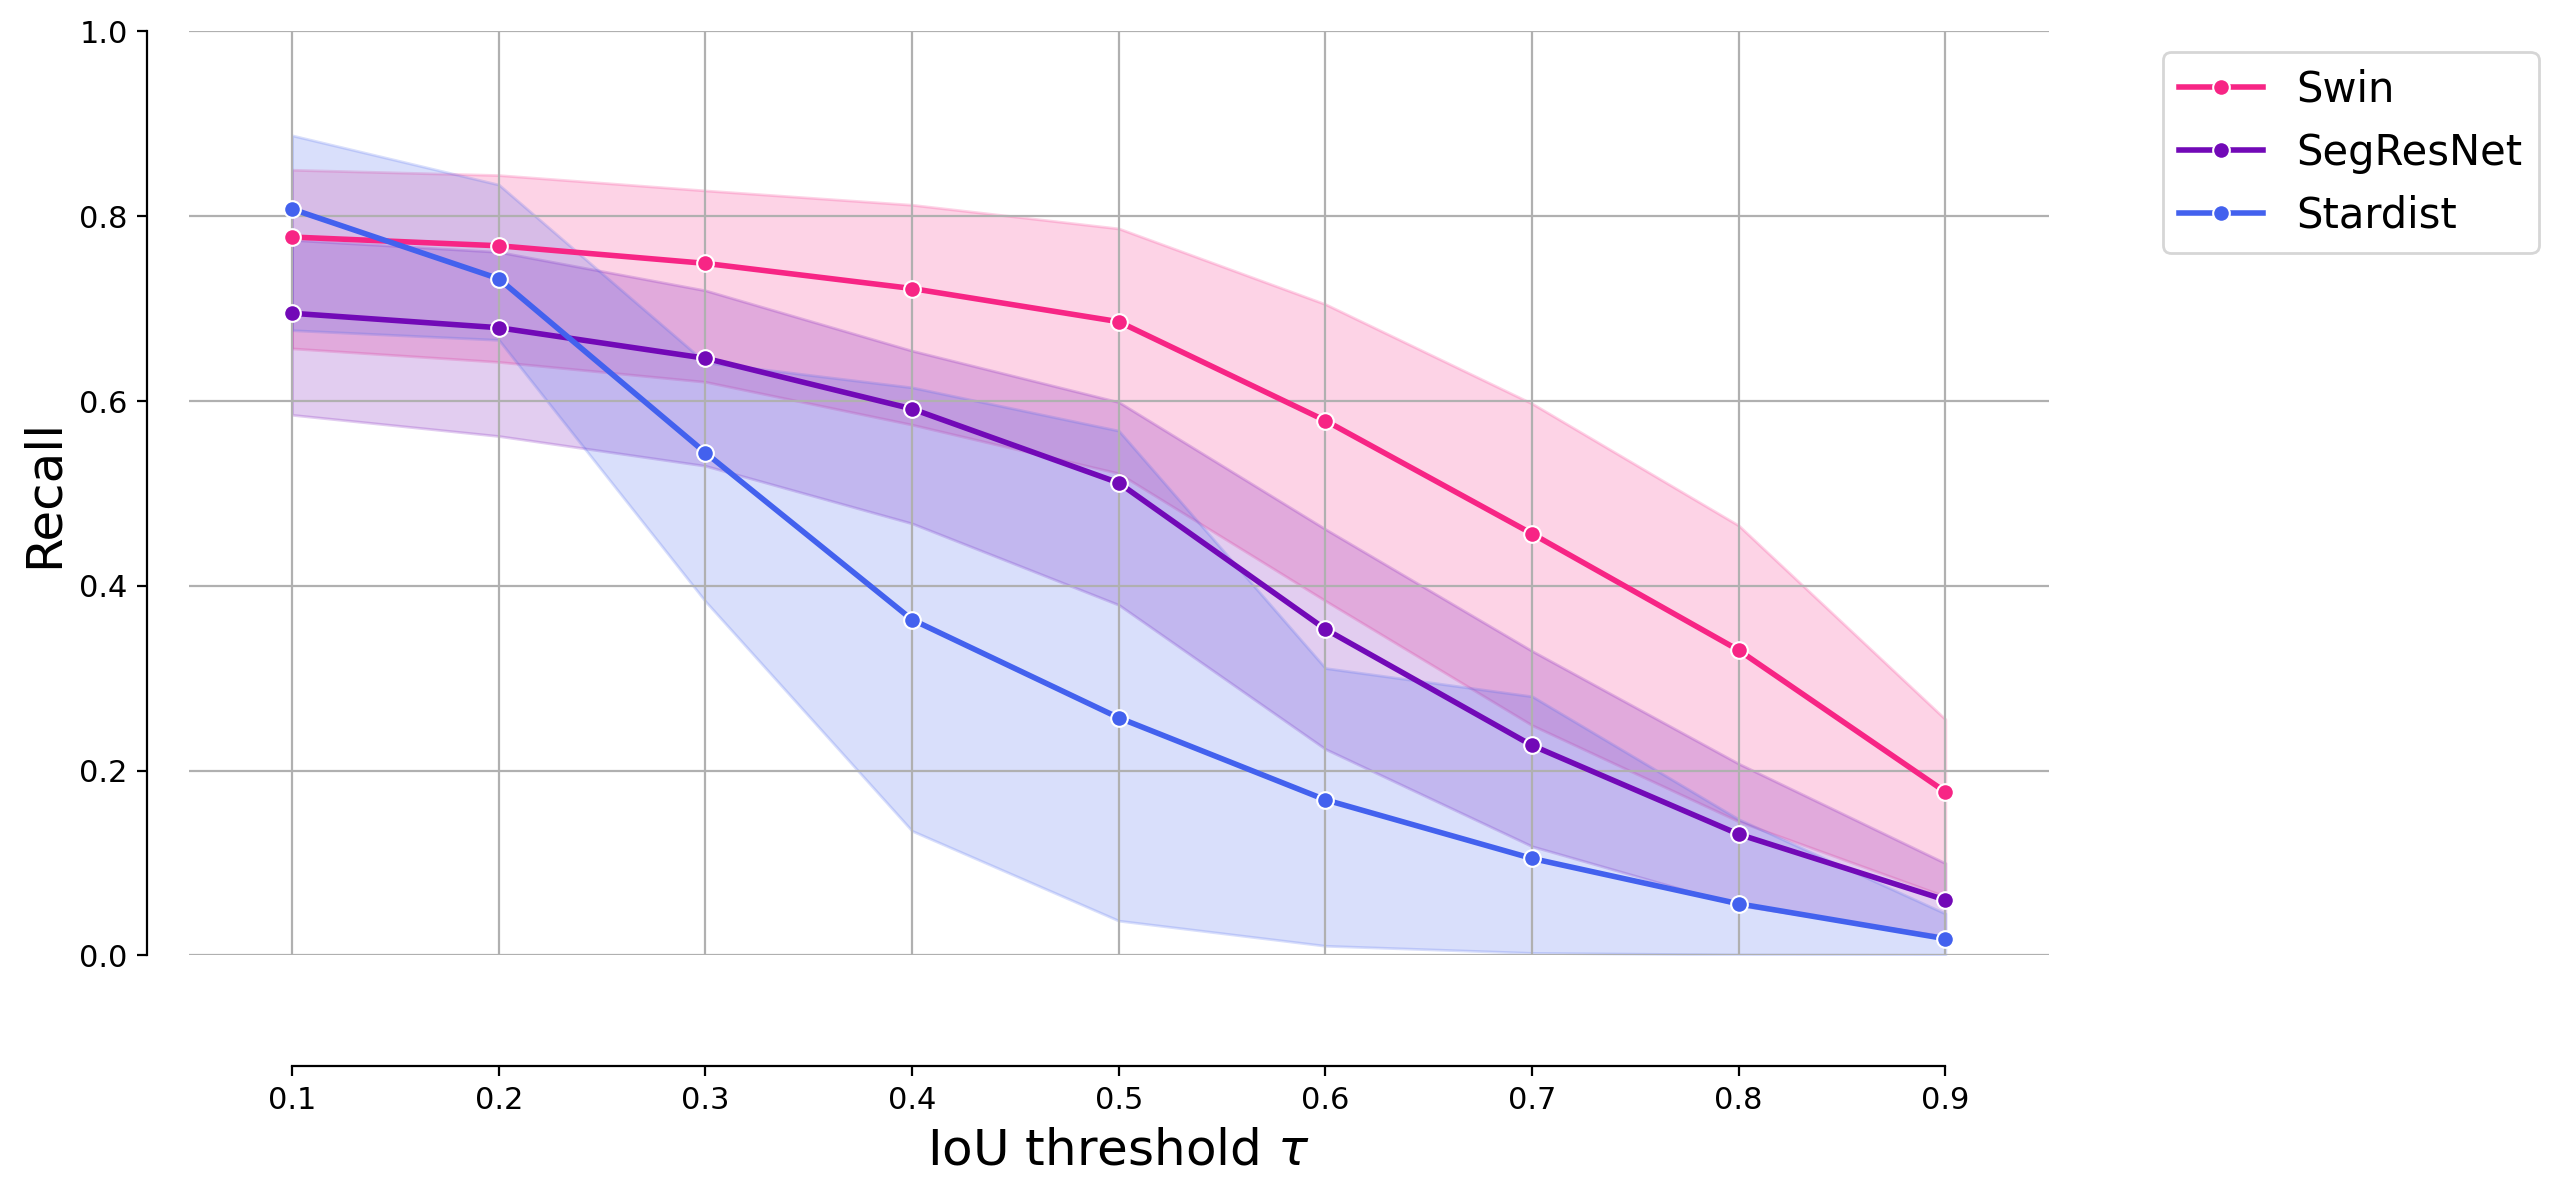

In [38]:
plot_stat_comparison_fold(df, stat="recall")

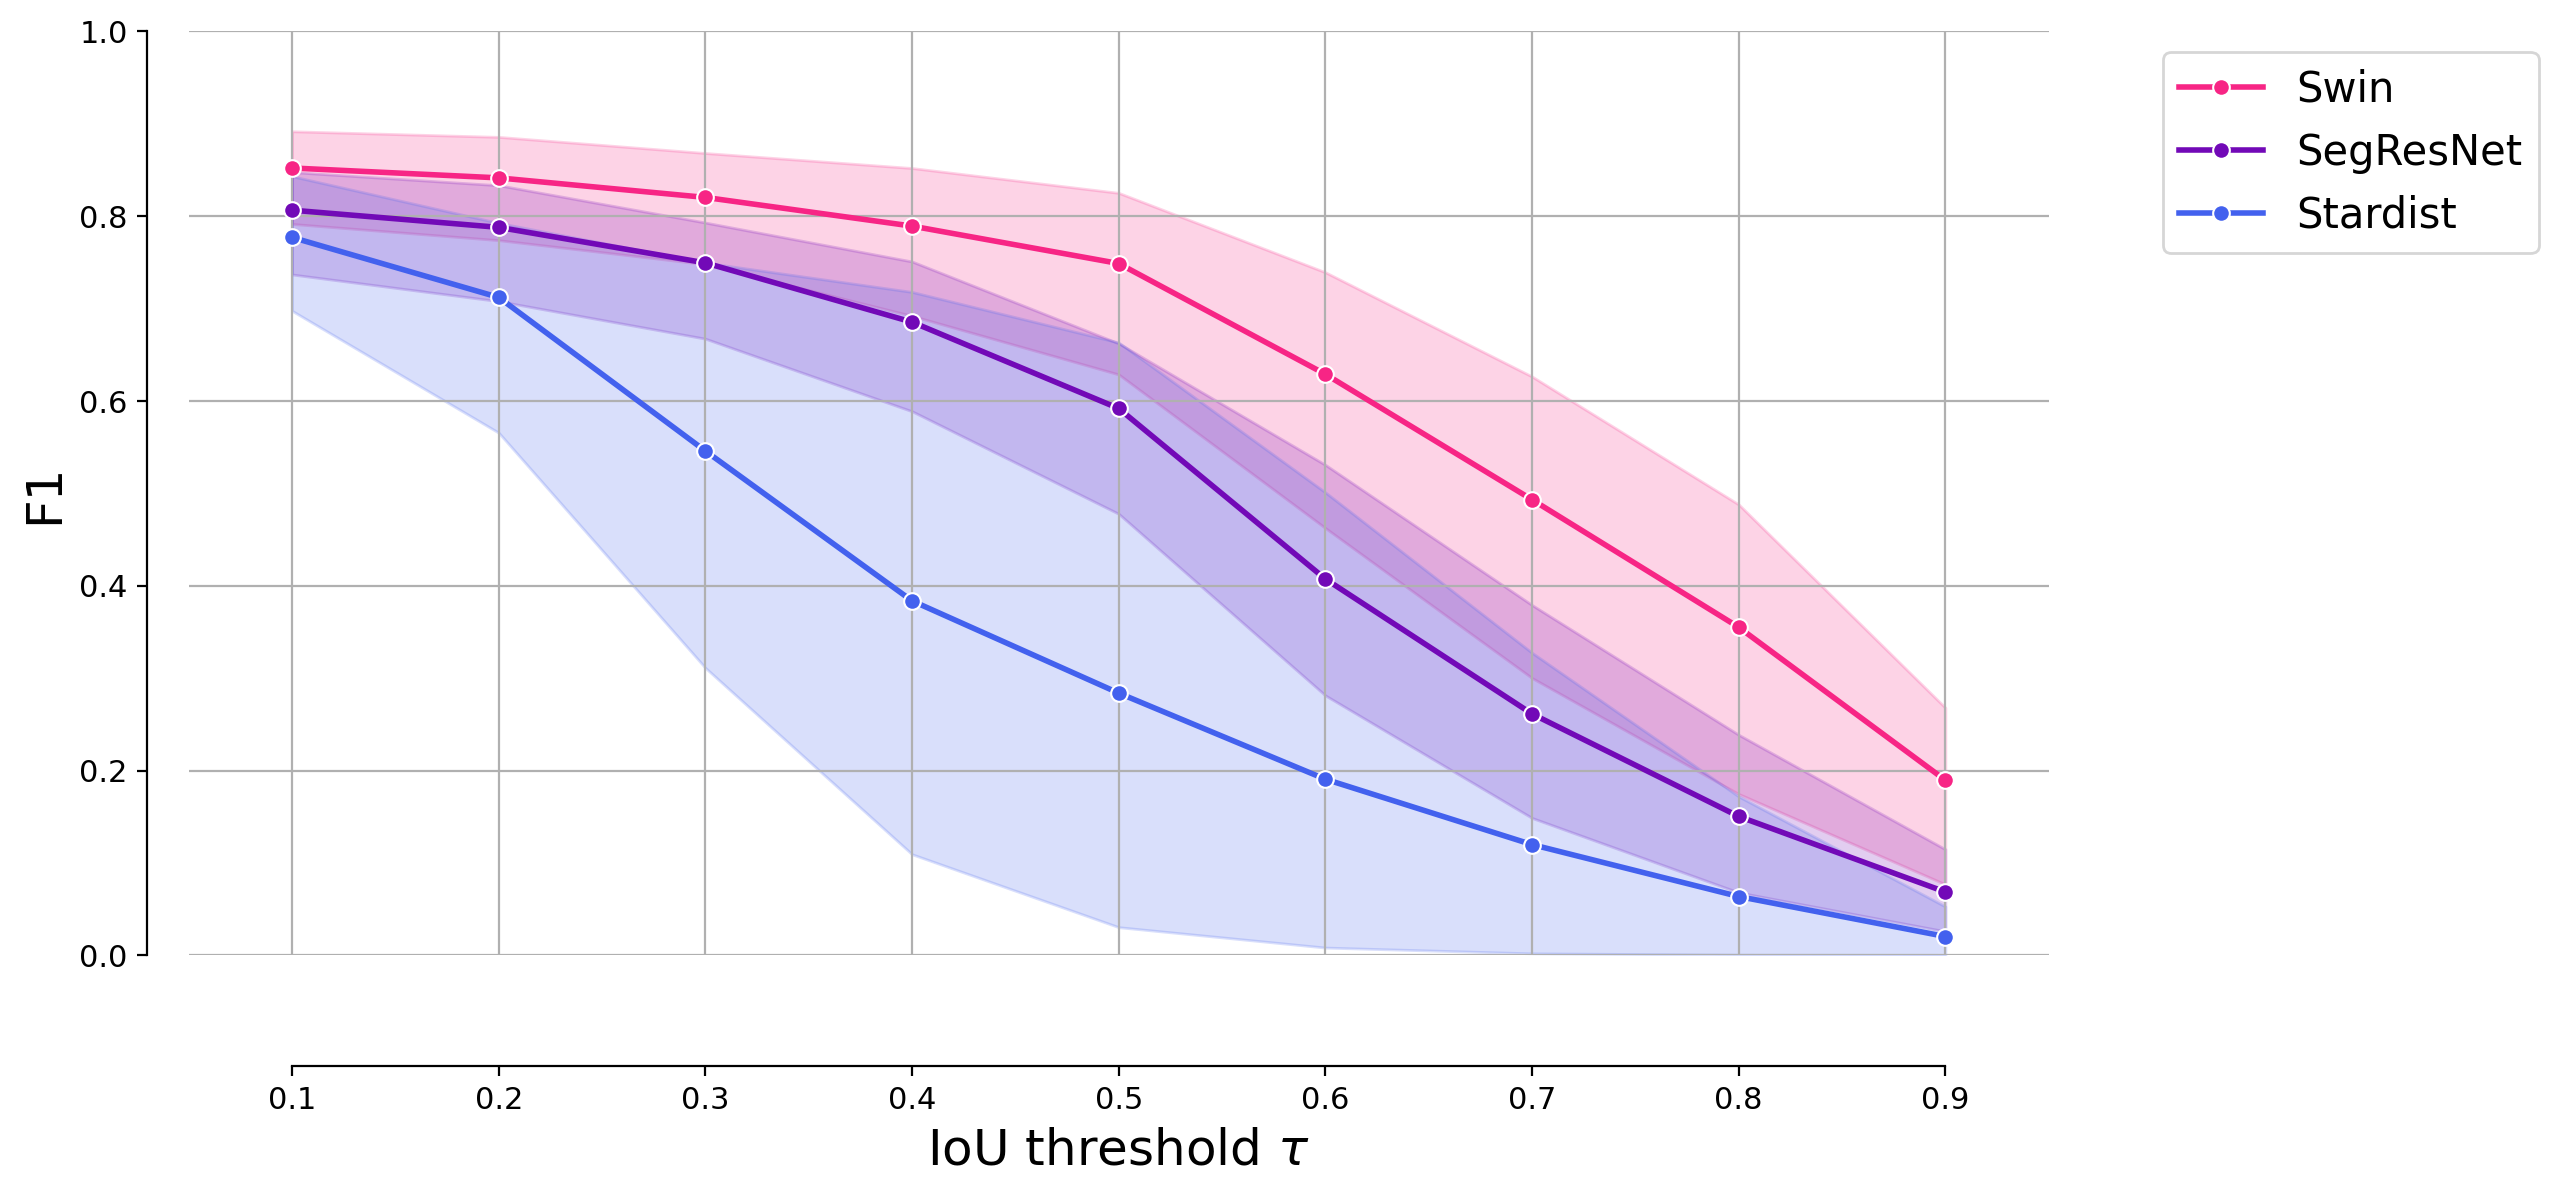

In [35]:
plot_stat_comparison_fold(df, stat="f1")

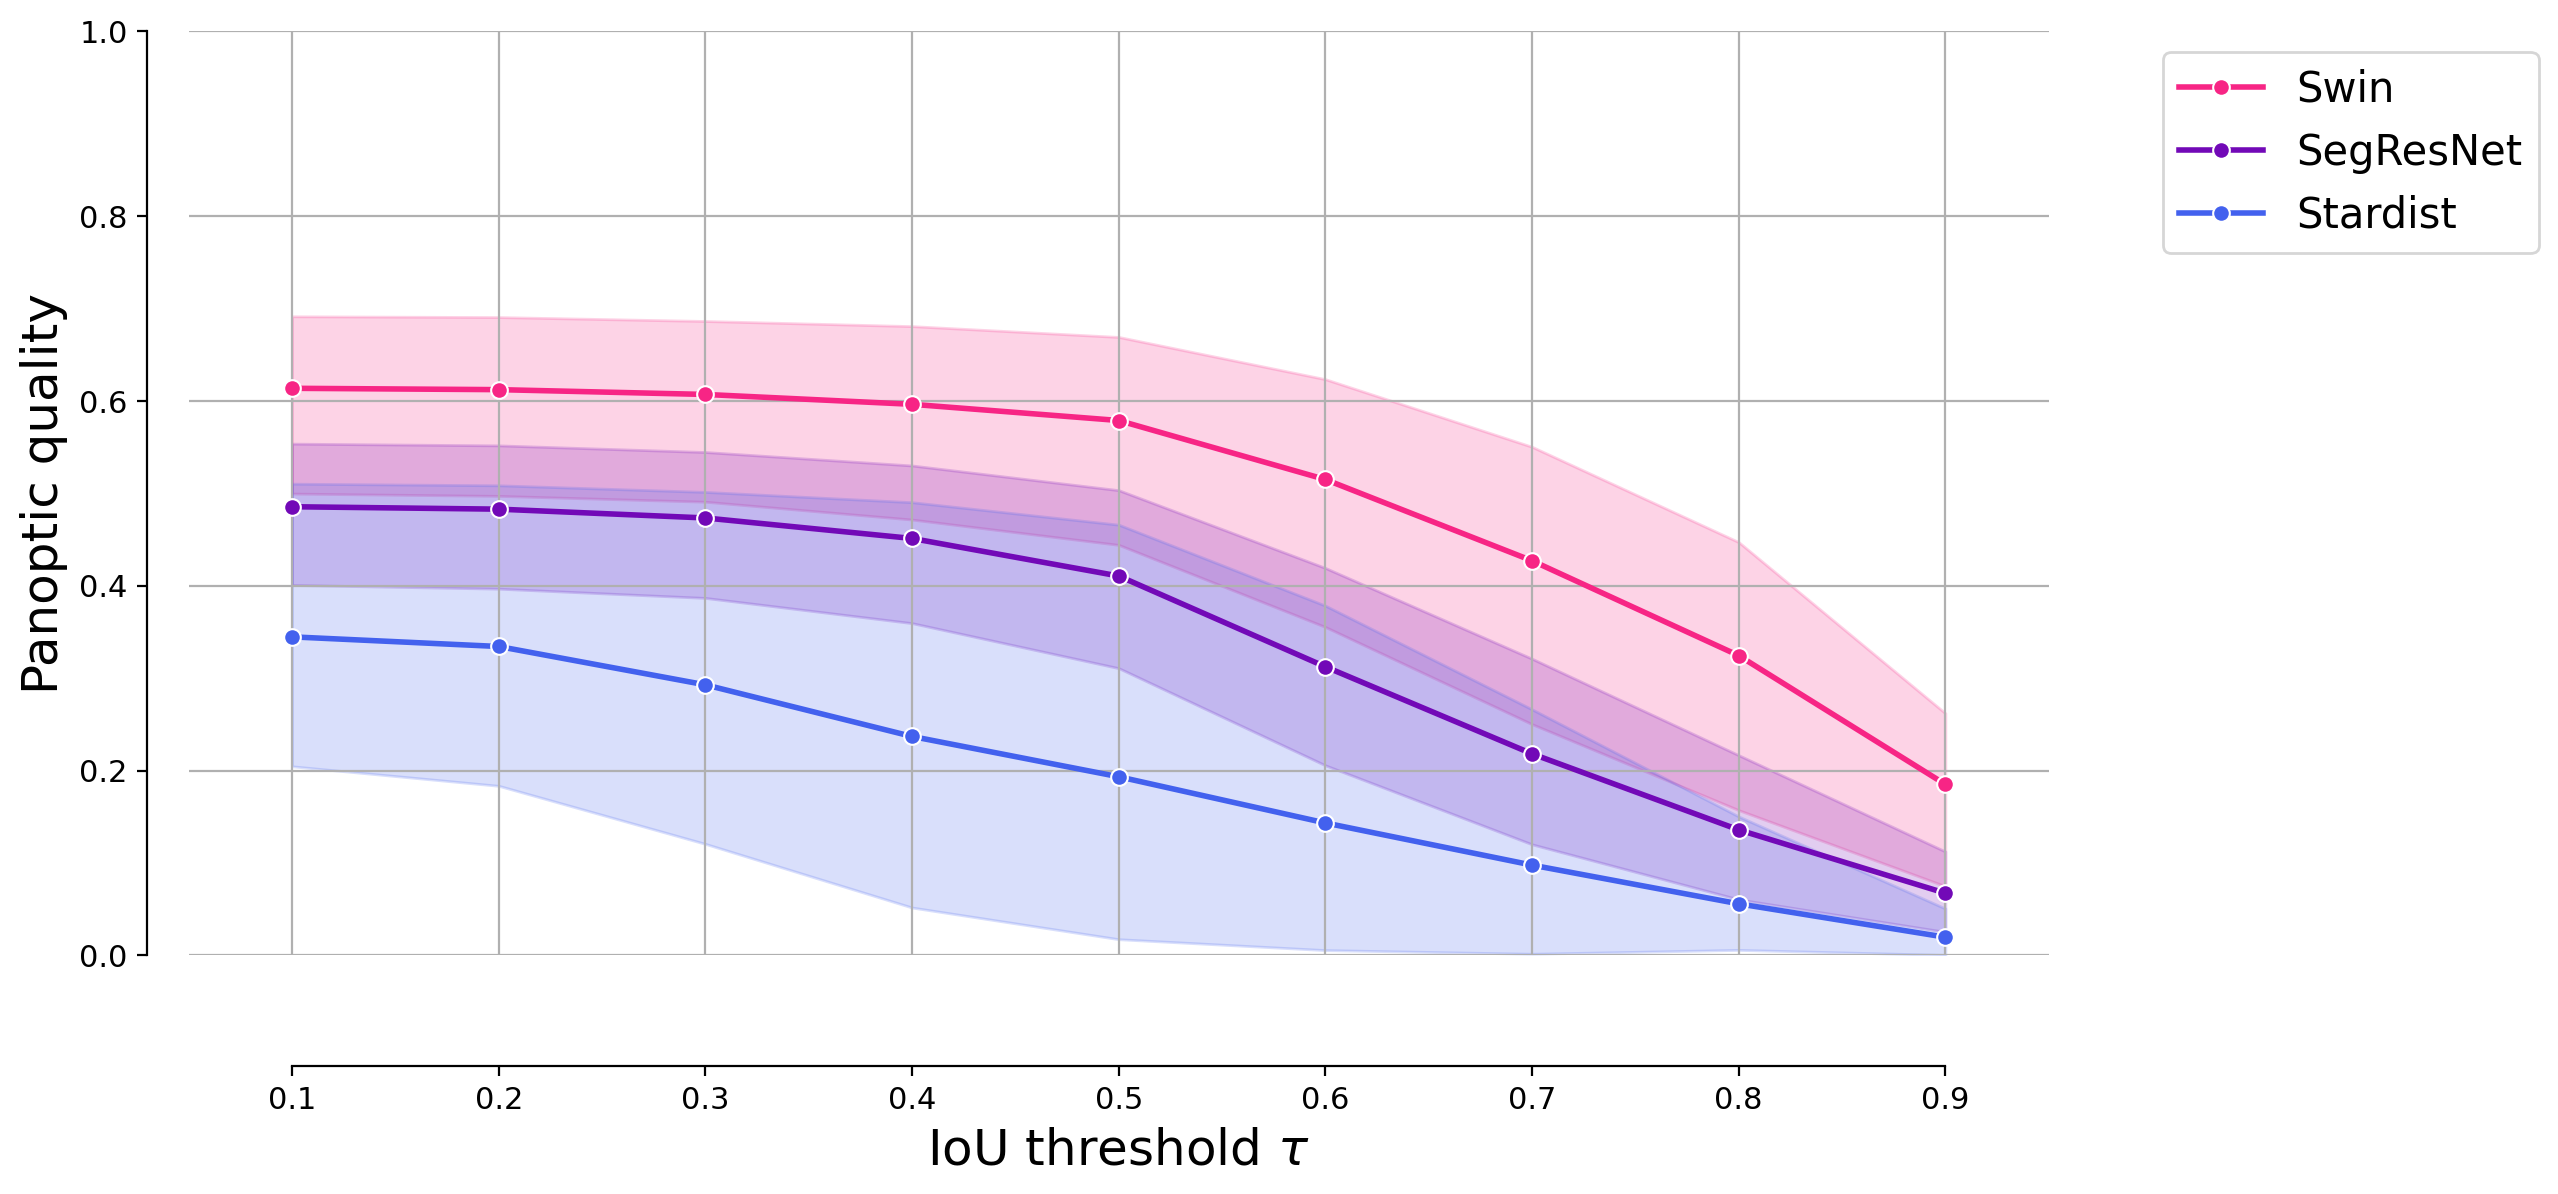

In [36]:
plot_stat_comparison_fold(df, stat="panoptic_quality")